<a href="https://colab.research.google.com/github/AJAV-TIP/ApplicationExample/blob/main/EOS_Zhang_et_al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EoS sentivity analysis for hydrogen uptake in Mg at 100 °C as Reported by (Zhang et al., 2021)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import animation, rc
from IPython.display import HTML;
rc('animation', html='html5');

In [ ]:
!pip install periodictable
import periodictable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for periodictable: filename=periodictable-1.7.0-py3-none-any.whl size=752513 sha256=972c801839f7d26cb4c76ab18a74d378a1f2d2176df61e46b1583e5b57bbfaf4
  Stored in directory: /root/.cache/pip/wheels/7e/19/a2/fef5d0ca2b1ad2b199e863a6e796ad9d5efc86563d80c91a0c
Successfully built periodictable


In [ ]:
!pip install CoolProp
import CoolProp.CoolProp as CP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 24.3 MB/s eta 0:00:00


Se importan los puntos de la curva, *i.e.*, $P_{i}$ y $P_f$

In [ ]:
url = ('https://raw.githubusercontent.com/AJAV-TIP/ApplicationExample/main/Zhang_et_al_2021.csv')
dataframe = pd.read_csv(url)
print(dataframe.info())
Pf = dataframe['Pf_(MPa)']
Pi = dataframe['Pi_(MPa)']

dataframe.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pi_(MPa)  24 non-null     float64
 1   Pf_(MPa)  24 non-null     float64
dtypes: float64(2)
memory usage: 512.0 bytes
None


,Pi_(MPa),Pf_(MPa)
0,0.000000,0.000001
1,0.009422,0.004886
2,0.022123,0.013800
3,0.028943,0.021579


Se identifican los elementos del material que se va a analizar y se consultan los pesos moleculares y las densidades de los elementos en la librería "`Periodictable`"



In [ ]:
# Lista de símbolos de elementos que deseas consultar
element_symbols = ['Mg']
Mw=[]
# Función para consultar y guardar los pesos moleculares en el vector
def get_Mw(symbols):
    for symbol in symbols:
        element = periodictable.elements.symbol(symbol)
        Mw.append(element.mass)

get_Mw(element_symbols)

rho = []

# Función para consultar y guardar las densidades en estado sólido en el vector
def get_rho(symbols):
    for symbol in symbols:
        element = periodictable.elements.symbol(symbol)
        rho.append(element.density)

get_rho(element_symbols)

Mw_H2 = 2*periodictable.elements.symbol('H').mass
rho_H = periodictable.elements.symbol('H').density

print("Densidades",rho,"g/cm^3")
print("Pesos moleculares",Mw,"g/mol")
print("Densidad del H2",rho_H,"g/cm^3")
print("Peso molecular del H2",Mw_H2,"g/mol")

Densidades [1.738] g/cm^3
Pesos moleculares [24.305] g/mol
Densidad del H2 0.0708 g/cm^3
Peso molecular del H2 2.01588 g/mol


In [ ]:
m_host = 0.070
Mw = np.array(Mw)
rho = np.array(rho)
Coeff = np.array([1])
Mw_host = np.dot(Mw,Coeff)
w_i = Mw*Coeff/Mw_host

In [ ]:
V_rev = 12.098
V_tube = 8.823
V_sc = 2.91

In [ ]:
T_rev = 298
T_tube = 298
T_sc = 373

In [ ]:
dfX = pd.DataFrame(index=range(len(Pi)),columns=['Leach','SRK', 'PR',	'GI'])

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0))

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1])

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'Hydrogen'))*T_rev)
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i]
    m_x[i] = m_host + n_sor[i-1]*Mw_host

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i])))
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2)

ld = round(X[i]+0.5)
dfX.Leach = pd.DataFrame(X)
dfX.Leach

0     0.000000
1     0.004065
2     0.015373
3     0.025195
4     0.225885
5     0.626438
6     1.035520
7     1.427045
8     1.844504
9     2.227195
10    2.618577
11    3.018491
12    3.401225
13    3.810216
14    4.218808
15    4.618904
16    5.001636
17    5.427846
18    5.810393
19    6.184731
20    6.515393
21    6.542434
22    6.542323
23    6.551642
Name: Leach, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0))

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1])

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'SRK::Hydrogen'))*T_rev)
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'SRK::Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'SRK::Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'SRK::Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'SRK::Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'SRK::Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i]
    m_x[i] = m_host + n_sor[i-1]*Mw_host

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i])))
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2)

ld = round(X[i]+0.5)
dfX.SRK = pd.DataFrame(X)
dfX.SRK

0     0.000000
1     0.004069
2     0.015386
3     0.025207
4     0.225905
5     0.626487
6     1.035602
7     1.427157
8     1.844647
9     2.227380
10    2.618798
11    3.018742
12    3.401555
13    3.810605
14    4.219237
15    4.619378
16    5.002182
17    5.428503
18    5.811058
19    6.185551
20    6.516476
21    6.543671
22    6.543617
23    6.553556
Name: SRK, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0))

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1])

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'PR::Hydrogen'))*T_rev)
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'PR::Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'PR::Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'PR::Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'PR::Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'PR::Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i]
    m_x[i] = m_host + n_sor[i-1]*Mw_host

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i])))
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2)

ld = round(X[i]+0.5)
dfX.PR = pd.DataFrame(X)
dfX.PR

0     0.000000
1     0.004082
2     0.015430
3     0.025245
4     0.225972
5     0.626650
6     1.035883
7     1.427543
8     1.845140
9     2.228022
10    2.619560
11    3.019613
12    3.402693
13    3.811951
14    4.220725
15    4.621023
16    5.004073
17    5.430777
18    5.813363
19    6.188391
20    6.520215
21    6.547944
22    6.548096
23    6.560150
Name: PR, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0))

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1])

    T1 = Pi[i]/(1*T_rev)
    T2 = Pf[i]/(1*T_rev)
    T3 = Pf[i-1]/(1*T_tube)
    T4 = Pf[i]/(1*T_tube)
    T5 = Pf[i-1]/(1*T_sc)
    T6 = Pf[i]/(1*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i]
    m_x[i] = m_host + n_sor[i-1]*Mw_host

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i])))
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2)

ld = round(X[i]+0.5)
dfX.GI = pd.DataFrame(X)
dfX.GI

0     0.000000
1     0.004095
2     0.015476
3     0.025282
4     0.226041
5     0.626825
6     1.036189
7     1.427969
8     1.845690
9     2.228737
10    2.620413
11    3.020589
12    3.403962
13    3.813454
14    4.222391
15    4.622867
16    5.006192
17    5.433321
18    5.815953
19    6.191570
20    6.524393
21    6.552718
22    6.553110
23    6.567490
Name: GI, dtype: float64

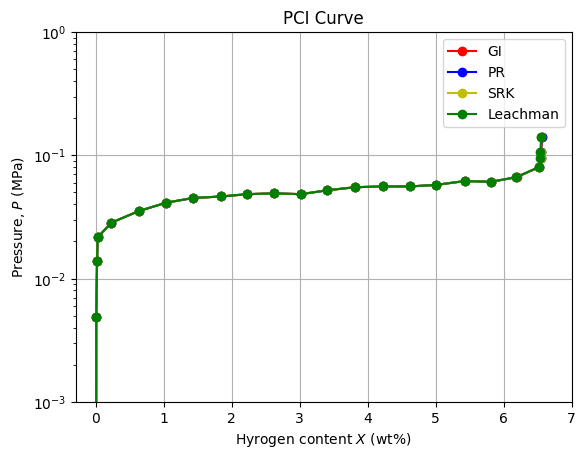

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Hyrogen content $X$ (wt%)')
ax.set_ylabel('Pressure, $P$ (MPa)')
ax.set_xlim([-0.3,7])
ax.set_ylim([0.001,1])
ax.set_yscale('log')
ax.grid(True)

ax.plot(dfX.GI,Pf,'ro-', label = 'GI')
ax.plot(dfX.PR,Pf,'bo-', label = 'PR')
ax.plot(dfX.SRK,Pf,'yo-', label = 'SRK')
ax.plot(dfX.Leach,Pf,'go-', label = 'Leachman')
ax.legend()
ax.set_title('PCI Curve')
plt.show()

In [ ]:
dfX

,Leach,SRK,PR,GI
0,0.000000,0.000000,0.000000,0.000000
1,0.004065,0.004069,0.004082,0.004095
2,0.015373,0.015386,0.015430,0.015476
3,0.025195,0.025207,0.025245,0.025282
4,0.225885,0.225905,0.225972,0.226041
5,0.626438,0.626487,0.626650,0.626825
6,1.035520,1.035602,1.035883,1.036189
7,1.427045,1.427157,1.427543,1.427969
8,1.844504,1.844647,1.845140,1.845690
9,2.227195,2.227380,2.228022,2.228737
